# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# keep matplotlib interactive
# NOTE: one must reload matplotlib to change of rendering style
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Data Description
Description of transactions

                                                

|                                       transactions.csv                                        |
|-----------------------------------------------------------------------------------------------|
| msno                   | user id  (letters, digits and special characters)                    |
| payment_method_id      | payment method   (masked)                                            |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          | true when customer opted in renewing its subscription automatically  |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |



### Transactions

In [2]:
transaction_dir = os.path.join(os.pardir, 'data', 'raw', 'transactions.csv')
df_transac = pd.read_csv(transaction_dir, parse_dates=['transaction_date', 'membership_expire_date'])

In [3]:
df_transac.count()

msno                      21547746
payment_method_id         21547746
payment_plan_days         21547746
plan_list_price           21547746
actual_amount_paid        21547746
is_auto_renew             21547746
transaction_date          21547746
membership_expire_date    21547746
is_cancel                 21547746
dtype: int64

In [4]:
# treat payment_method_id as a category
df_transac.payment_method_id = df_transac.payment_method_id.astype('category')
# same for user
df_transac.msno = df_transac.msno.astype('category')
# convert relevant columns to boolean
df_transac.is_auto_renew = df_transac.is_auto_renew.astype(bool)
df_transac.is_cancel = df_transac.is_cancel.astype(bool)

In [5]:
df_transac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      category
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             bool
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                 bool
dtypes: bool(2), category(2), datetime64[ns](2), int64(3)
memory usage: 1.0 GB


In [6]:
def plot_bar(df, bar_list, is_Norm=True):
    """
        Make a bar plot using dataframe df and associated columns in bar_list
        is_Norm will normalize distribution by counts
        df: pandas DataFrame
        bar_list: list of column names
    """
    # keep 2 columns and compute number of rows needed in subpots
    subrows = int(np.ceil(len(bar_list) / 2))
    discard_last_ax = bool(len(bar_list) % 2)
    
    # special case when there is only one column specified
    # then keep one figure and make it bigger
    if subrows == 1 and discard_last_ax:
        _ , ax = plt.subplots(figsize=(9,5))
        ax = [ax]
    else:
        _ , ax = plt.subplots(subrows, 2)
        ax = ax.flatten()
    for k, colname in enumerate(bar_list):
        
        # select column and make bar plot
        s_colname = df[colname]
        distrib = s_colname.value_counts(normalize = is_Norm).sort_index()*100
        distrib.plot(kind='bar', ax=ax[k], color='b')
        
        # add percent character to y tick label if plot normalized
        if is_Norm:
            # add percent on y axis labels, uses numerical value of each tick (just in case scale has changed)
#             ax[k].set_yticklabels([ '{:.0f}%'.format(l)  for l in ax[k].get_yticks()])
            pass
        else:
            ax[k].set_ylabel('Count')
                
        # reformat existing x ticklabels to integer (may not be required)
        # When numeric columns have Nans then it will show float number
        # ax[k].set_xticklabels([ '{:.0f}'.format(float(l.get_text()))  for l in ax[k].get_xticklabels()])
        
        # add title
        ax[k].set_title(distrib.name + ' Distribution')
        
        # reset x axis label to 45 rotation
        ax[k].tick_params(axis = 'x', rotation = 45)
        
        # add x axis label
        ax[k].set_xlabel(distrib.name)
        
    # decide to keep last axes
    if discard_last_ax and subrows > 1: ax[-1].set_visible(False)
    plt.tight_layout()

### Payment ID method
Payment ID 41 represents more than 50% of transactions

<IPython.core.display.Javascript object>


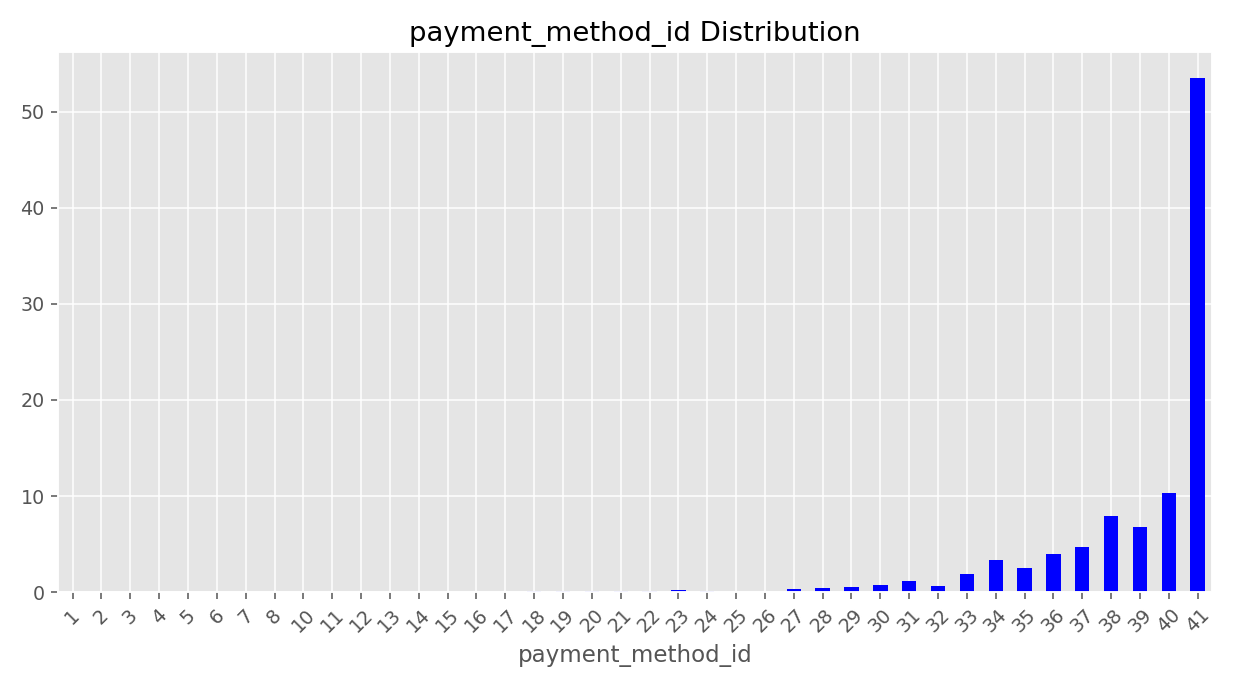

In [7]:
plot_bar(df_transac, ['payment_method_id'])

### Payment Plan in days
There is a lot more variety in subscriptions than I expected
from [KKBOX website](https://help.kkbox.com/hk/zh-tw/billing/pay-types/260), here are the options:
1. Options are monthly plan (30/31 days) with automatic renewal (is_auto_renew true) 
2. Single purchase, no automatic renewal but more expensive:
    3. 30 days
    4. 90 days (plus 7 days bonus?)
    5. 180 days (plus 21 days bonus?)
    6. 365 days (plus 50 days bonus?)
There are discount programs too (getting a credit card with their partners and so on)

0 days doesn't make sense. Because it is low percentage, we can discard it.

We may want to keep only plans shorter than 30/31 days as predicitons are made on a monthly basis.
Indeed, longer subscription means customer will not churn next month

<IPython.core.display.Javascript object>


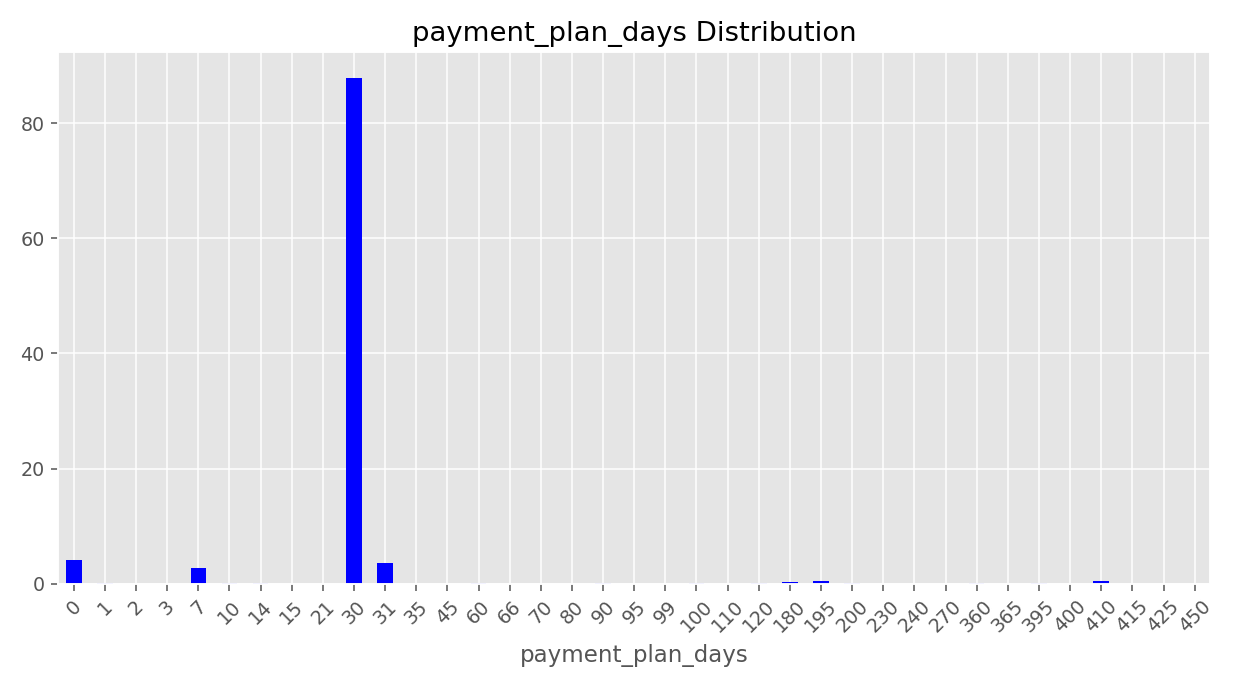

In [8]:
plot_bar(df_transac, ['payment_plan_days'], is_Norm=True)

### A closer look at 0 day plans

Records of 0 day plans also have a list price of 0. All other columns appears to contain legitimate information.

Therefore, payment plan days can be inferred by looking at the time difference between expiration date and transaction date. However, when cancellation is active, it will not work as expiration date is not meaningful. In this latter case, we could look at previous transaction from each respective user if needed.

Note that those transactions occur in 2015 except for 3 in 2016 and 1 in 2017.

In [9]:
# select rows where payment plan days are zero
df_zero_day = df_transac[df_transac.payment_plan_days == 0]

In [10]:
# number of missing value is small
print( '{:.2f}% of total transactions'.format(df_zero_day.shape[0]/df_transac.shape[0] * 100))

4.04% of total transactions


In [11]:
# show that list prices are also zero
df_zero_day.plan_list_price.sum()

0

#### Replacing 0 payment plan days with no active cancellation

Here we assume that expiration and membership dates are valid and number of days ellapsed between those two dates correspond to the plan duration. We should check if this is true for non-zero payment plan days.

In [12]:
df_temp = df_transac[(df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False)].copy()

In [13]:
# compute payment plan days from transaction date and expiration date
df_temp['delta_days'] = (df_temp['membership_expire_date'] - \
                         df_temp['transaction_date']).astype('timedelta64[D]').astype('int64')

In [14]:
df_temp_match = df_temp.loc[df_temp.delta_days == df_temp.payment_plan_days]
print('Percent of Payment Plan Days matching delta plan days = {:.1f} %'.format(\
                                    df_temp_match.shape[0]/df_temp.shape[0]*100))

Percent of Payment Plan Days matching delta plan days = 33.8 %


Using transaction date and expiration date works only for 33.8% of known transactions!

When did it work?

Most likely hapenning when automatic renewal is enabled and transaction date is at the end of the month. Not a reliable method!!!

In [15]:
df_temp_match.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,delta_days
22,pArK2x3bNZW0sAYaFg0h5c3xkx+2RhLa0RXG88jpt6I=,37,30,149,149,True,2015-10-01,2015-10-31,False,30
62,svvuo4JCElN6TLQZUrMPLuZMpRwcaePM02X3ybNN1dg=,38,30,149,149,False,2015-11-30,2015-12-30,False,30
63,uxUOp7bS37/tqyaiJZnGVAg68YyA7AXEgJ5WDTb6jYE=,37,30,149,149,True,2015-12-01,2015-12-31,False,30
66,aUB5tfRl4tO/EefPzjhKOmAuCVqsmHWYDVgBPpC1/ps=,38,10,0,0,False,2015-12-01,2015-12-11,False,10
67,vIpqkb/ck3zAOqMgqirkrM1rI49dNLPREdznv2X6eTQ=,38,30,149,149,False,2015-12-01,2015-12-31,False,30


### Better approach to substitute 0-day payment plan
Looking at the time ellapsed between two consecutives expiration date is a better way to determine payment plan days. Current transaction date must be anterior to previous expiration date meaning user always renewed before the expiration date.

When there is no overlap between successive transaction and expiration dates, then we can estimate using the difference in days between current transaction and its associated expiration date.

For active cancellation, we can propagate forward last known plan duration.

Instead of looping through each group (i.e. using groupby), we can apply our calculation on the whole dataframe at once if we know the index of each customer first transaction. Indeed, we don't want to propagate expiration date from one customer to another.

In [16]:
# sort dataframe by msno, transaction date then expiration date
df_transac.sort_values(['msno', 'transaction_date', 'membership_expire_date'], inplace=True)

In [17]:
# group by users, no need to sort as it is pre-sorted
df_group = df_transac.groupby('msno', sort=False)

Collect index of user's first transaction

In [18]:
import time
start_time = time.time()
# keep track of each user's first transaction
first_trans = []

# aggregation function first set msno as indexes (original indexes are lost)
for user_name, user_df in df_group:
    # get transactions from user
    first_trans.append(user_df.index[0])
    
print("--- %s seconds ellapsed in for loop---" % (time.time() - start_time))

--- 386.2830135822296 seconds ellapsed in for loop---


In [19]:
# create new column showing preceding expiration date for each record
# expect for the first record obviously
# Note: must use .values otherwise it will attempt to align data
df_transac.loc[df_transac.index[1:],'prior_expiration'] =\
                            df_transac.loc[df_transac.index[:-1],'membership_expire_date'].values

In [20]:
# set each user's first transaction to pd.Timedelta('nan') (aka NaT) for prior_expiration.
# It was set to last transaction of preceding user from last operation.
df_transac.loc[first_trans, 'prior_expiration'] = pd.Timedelta('nan')

#### Estimate payment plan days for users who always renew in time.

In [21]:
# compute delta days when transaction date is anterior to prior expiration date and no active cancellation
# This condition captures all transactions when auto renew is enabled unless a user starts again 
# his membership after a while and chooses automatic renewal
# OR user's first transaction (no existing prior expiration date)
# NOTE: inequality comparison with NaT will always yield False
crit_mem = (df_transac.transaction_date <= df_transac.prior_expiration) & (df_transac.is_cancel == False)

In [22]:
# percentage of transactions renewed on time WITHOUT automatic renewal
s_timely_renew = df_transac.loc[crit_mem, 'is_auto_renew']
no_auto_renew_fraction = 1 - (s_timely_renew.sum() /len(s_timely_renew))
print('Percentage of timely transaction without automatic renewal = {:.1f}%'.format(no_auto_renew_fraction*100))

Percentage of timely transaction without automatic renewal = 3.8%


In [23]:
# estimate payment plan days
df_transac.loc[crit_mem,'delta_days'] = (df_transac.loc[crit_mem, 'membership_expire_date'] - \
                                         df_transac.loc[crit_mem, 'prior_expiration']
                                        ).astype('timedelta64[D]')

#### Estimate payment plan days for independent transactions (no transaction date/prior expiration date overlap)

In [24]:
# user didn't keep up with its membership in a timely manner and no active cancellation
# For user's first transaction, we cannot tell if there is an overlap or not
crit_ept = (df_transac.delta_days.isnull()) & (df_transac.is_cancel == False) & (~df_transac.index.isin(first_trans))

In [25]:
# when there is no overlap with prior transaction, use expiration-transaction date difference
df_transac.loc[crit_ept, 'delta_days'] = (df_transac.loc[crit_ept, 'membership_expire_date'] - \
                                         df_transac.loc[crit_ept, 'transaction_date']
                                        ).astype('timedelta64[D]')

#### Estimate payment plan days when cancellation is active
At this point we have user's first transactions and active cancellation unfilled. <br>
NOTE: active cancellation only happens when automatic renewal is in place.

In [26]:
# Use fillna() with forward fill, intended for cancellation with prior history for each user
# When a user cancels, he/she signed up at the first place
df_transac.delta_days.fillna(method='ffill', inplace=True)

# reset each user's first transaction to nan
df_transac.loc[df_transac.index.isin(first_trans), 'delta_days'] = np.nan

### Expiration date inconsistency
When delta_days is negative, it means membership expiration date is not in a chronological order. It indicates poor data collection and there is no consistent way to fix it unless we know how data were recorded. We have no choice but to drop all transactions from users with no consitency in expiration date. (There is only 4459 records, and often multiple records per user)

In [27]:
# select users who have one or more negative estimated plan duration
users2remove = set(df_transac.loc[(df_transac.delta_days <= 0), 'msno'].values)

# remove users with inconsistency in expiration date
df_transac = df_transac.loc[ ~df_transac.msno.isin(users2remove) ,:]

### Missing payment plan days in Unique transactions
When users have a unique transaction and payment plan days is missing (zero), it is tricky to find a replacement. We know transaction/expiration dates are not reliable without prior history and plan list price is zero.

We could try to rely on actual paid price. However, non-missing payment plan days shows that actual amount paid occasionally varies for the same payment plan days. Even if we select the most common actual amount, it corresponds to multiple payment plan days.
It will most likely add more noise than signal trying to fill missing values based on the most common of most common value.

In [28]:
# number of transactions per user
s_trans_num = df_group.size()

# list of user's having just one transaction
users_unq_trans = s_trans_num[s_trans_num == 1].index

In [29]:
# remove users with single transaction and missing payment plan days
crit_single = (df_transac.msno.isin(users_unq_trans)) & (df_transac.payment_plan_days == 0)
df_transac = df_transac.loc[ ~crit_single ,:]

### Payment plan days missing value as first transaction
At this point delta days has missing value only for the first transaction of each user.

In [30]:
# verify only user's first transaction do not have a delta days estimate
((df_transac.index.isin(first_trans)) == (df_transac.delta_days.isnull())).all()

True

* We can backpropagate payment plan days as long as auto renew is true and there is no active cancellation. The second transaction must be auto renew too or it is an active cancellation with the right payment plan days either way.

In [31]:
# propagate delta days backward, intended for auto renew true and no active cancellation cases
df_transac.delta_days.fillna(method='bfill', inplace=True)

In [32]:
# reset first transactions to nan when both cancellation and auto renew matches (true or false)
crit_reset = (df_transac.index.isin(first_trans)) & (df_transac.is_cancel == df_transac.is_auto_renew)
df_transac.loc[crit_reset, 'delta_days'] = np.nan

* When both auto renew and cancellation are false, it means a user subscribed on his own agenda. Without prior history, we don't know if this is an independent transaction. Based on the existing data, it appears that transaction-expiration time difference does work for 90% of transactions given the same conditions. Because the last 10% has high error, we will simply disregard those transactions (~12k over 21M+ total). Also actual amount is not reliable.

In [33]:
crit_inde = (df_transac.payment_plan_days == 0) & (df_transac.index.isin(first_trans)) & \
            (df_transac.is_auto_renew == False) & (df_transac.is_cancel == False)

In [34]:
crit_inde.sum()

12252

In [35]:
df_transac = df_transac[~crit_inde]

* When both auto renew and cancel are true then we only have actual amount as a hint. We already saw it wasn't reliable (see unique transactions). Thus we will disregard those (only 151 transactions).

In [36]:
crit_cancel_auto = ((df_transac.payment_plan_days == 0) & df_transac.delta_days.isnull())

In [37]:
crit_cancel_auto.sum()

151

In [38]:
df_transac = df_transac[~crit_cancel_auto]

Our estimated monthly plan duration is always between 28 and 32 days depending on the month. Therefore, we adjust our estimation to 30 days. The same operation can be done for payment plan days.

In [39]:
crit_30_delta = (df_transac.delta_days >= 28) & (df_transac.delta_days <= 32)
df_transac.loc[crit_30_delta, 'delta_days'] = 30

In [40]:
crit_30 = (df_transac.payment_plan_days >= 28) & (df_transac.payment_plan_days <= 32)
df_transac.loc[crit_30, 'payment_plan_days'] = 30

#### Replace missing payment plan days!

In [41]:
crit_plan = df_transac.payment_plan_days == 0
df_transac.loc[crit_plan, 'payment_plan_days'] = df_transac.loc[crit_plan, 'delta_days']

In [42]:
# drop delta days and prior expiration
df_transac = df_transac.drop(['delta_days', 'prior_expiration'], axis = 1)

As a result of filling missing values, we have a wider variety in payment plan days.

In [43]:
num_of_plan_ini = df_transac.loc[~crit_plan, 'payment_plan_days'].value_counts().count()
num_of_plan = df_transac.payment_plan_days.value_counts().count()
print('Initial number of plan duration = {} \
      \nNumber of plans duration after replacement = {}'.format(num_of_plan_ini, num_of_plan))

Initial number of plan duration = 34       
Number of plans duration after replacement = 111


Let's group plan duration by the following intervals in days:
| 0 - 7 | 8 - 29 | 30 - 89 | 90 - 179 | 180 - 364  | 365 - 485 |

Those intervals are based on the information available on KKBOX website. For instance, there is a 30 days and 90 days plan hence we make an interval between 30 and 89 days. The assumption is you can only have extra days in your subscription.

In [44]:
# create custom intervals (bin edges will be left inclusive) in increasing order
days_plan = [0, 8, 30, 90, 180, 365, 485 ]

# compile labels
days_plan_upperbounds = [d-1 for d in days_plan[1:-1] ]
days_plan_upperbounds.append(days_plan[-1])
days_plan_labels = [ "{} - {}".format(l,u) for l,u in zip(days_plan[:-1], days_plan_upperbounds) ]

print('Bin edges = {}'.format(days_plan))
print('Associated labels = {}'.format(days_plan_labels))

Bin edges = [0, 8, 30, 90, 180, 365, 485]
Associated labels = ['0 - 7', '8 - 29', '30 - 89', '90 - 179', '180 - 364', '365 - 485']


In [45]:
# create new column with plan duration category
df_transac['plan_duration'] = pd.cut(df_transac.payment_plan_days, days_plan, right=False, labels=days_plan_labels)

<IPython.core.display.Javascript object>


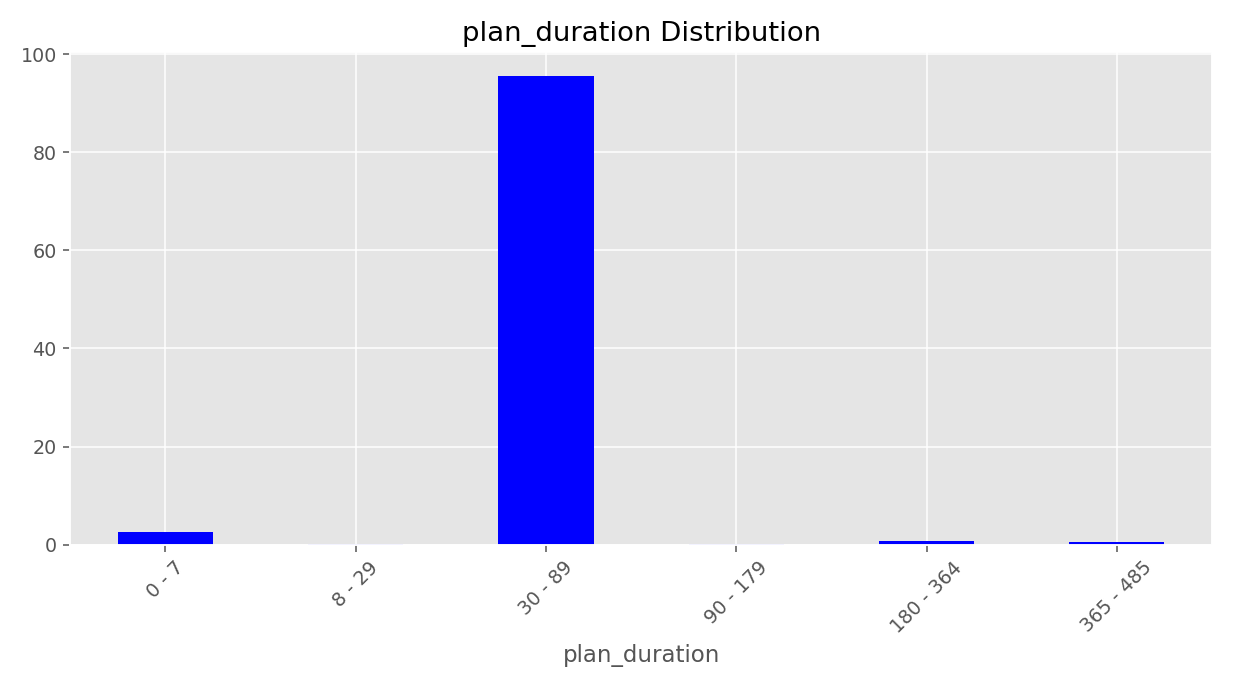

In [46]:
plot_bar(df_transac, ['plan_duration'])

### Auto-renew and active cancellation
Most people who have auto renewal active also don't cancel actively. It is consistent with the fact that most customers don't churn.

<IPython.core.display.Javascript object>


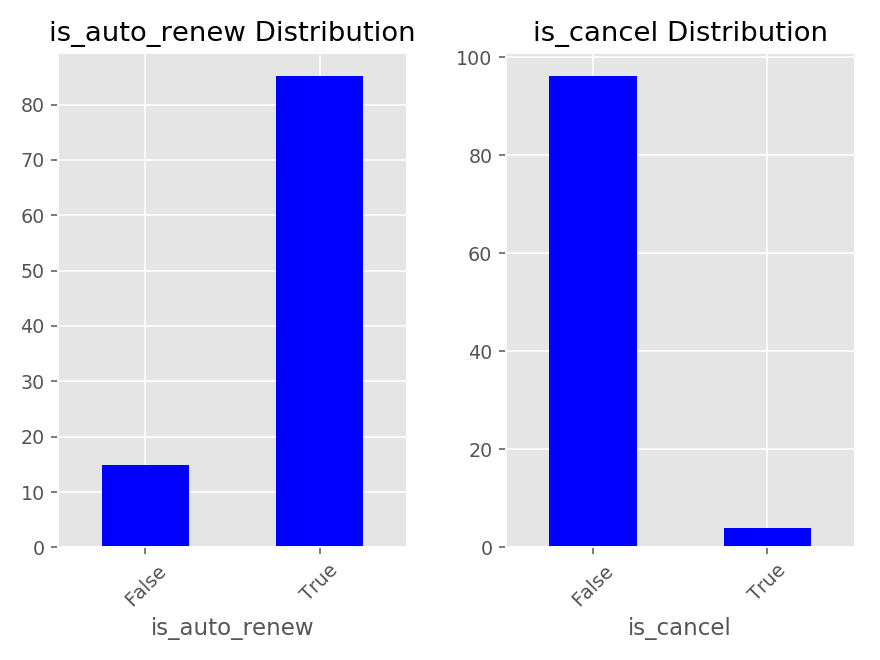

In [47]:
plot_bar(df_transac, ['is_auto_renew' , 'is_cancel'])

In [48]:
# number of active cancellation with automatic renewal enabled
count_cancel_auto = df_transac.loc[df_transac.is_auto_renew == True, 'is_cancel'].sum()
count_auto = (df_transac.is_auto_renew == True).sum()
print('Percentage of active cancellation while auto renew activated = {:.2f}%'.format(count_cancel_auto / count_auto *100))

Percentage of active cancellation while auto renew activated = 4.59%


### Plan list price
90% of list price are below 150. There are 0 list price which indicates missing values.<br>
Top 3 most freqent list price are 99, 129 and 149.

<IPython.core.display.Javascript object>


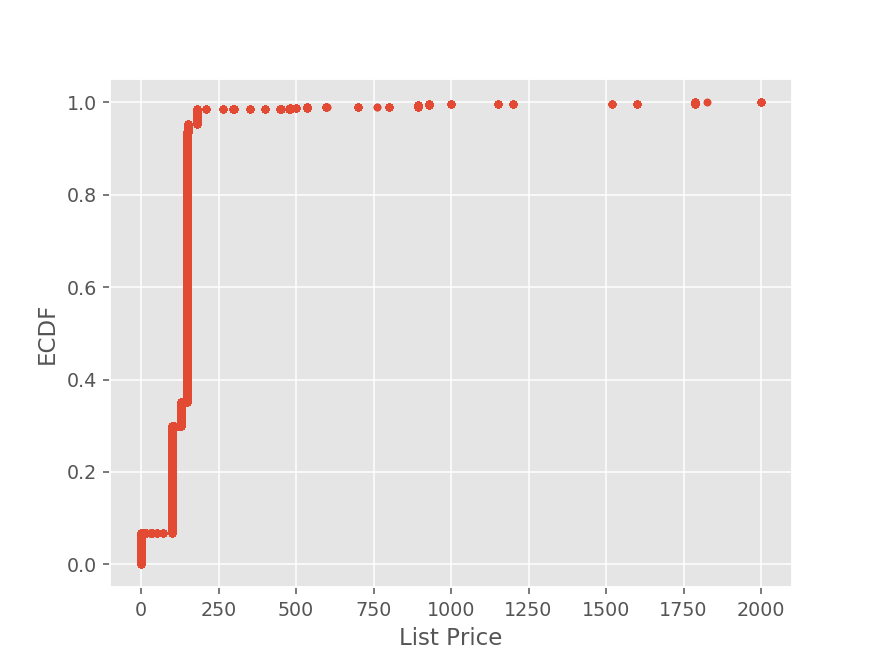

Text(0,0.5,'ECDF')

In [49]:
_ , axpllist = plt.subplots()
pl_x = df_transac.plan_list_price.sort_values().values
pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
axpllist.plot(pl_x, pl_y, '.')
axpllist.set_xlabel('List Price')
axpllist.set_ylabel('ECDF')

Let's see if we can replace those missing values. Note we won't find a list price replacement for new estimated payment plan days so we should use our plan duration intervals.

In [50]:
# select transactions with no missing list price and group by plan duration then list price
df_plan_grouped = \
        df_transac[df_transac.plan_list_price != 0].groupby(['plan_duration', 'plan_list_price'])

In [51]:
# frequency count of plan duration-list price combination
s_listprice_rpl = df_plan_grouped.msno.count()
# s_listprice_rpl.head(50)

There are multiple list price for the same plan duration! I would think there should be a unique list price for each plan. This is not the case even if we look at the same data per payment plan days and per calendar year. <br>
Thus we will pick the most frequently occurring plan duration and list price combination.

In [52]:
# move plan_duration from index to column and regroup by keeping the most frequent list price
s_listprice_rpl = s_listprice_rpl.reset_index(level = 0).groupby('plan_duration').msno.nlargest(n=1)

In [53]:
# move list price from index to column
s_listprice_rpl = s_listprice_rpl.reset_index(level = 1)

In [54]:
# remove count column (msno here)
s_listprice_rpl.drop('msno', axis = 1, inplace = True)

In [55]:
s_listprice_rpl

,plan_list_price
plan_duration,
0 - 7,35
8 - 29,50
30 - 89,149
90 - 179,480
180 - 364,894
365 - 485,1788


Substitute zero list price with our mapping.

In [56]:
df_transac.loc[df_transac.plan_list_price == 0, 'plan_list_price'] = \
                    df_transac.loc[df_transac.plan_list_price == 0, 'plan_duration'].map(s_listprice_rpl.plan_list_price)

### Subscription cost per subscription length
How do subscription length scale with list price ? <br>
One can observe the list price going up with subscription length globally. However, there are overlaps in list price between plan duration except for long term plans (> 365 days) whic are clearly the most expensive.

Create bar plot for each auto renew state (True or False). Does not include cancellation transactions as it would be redundant.

<IPython.core.display.Javascript object>


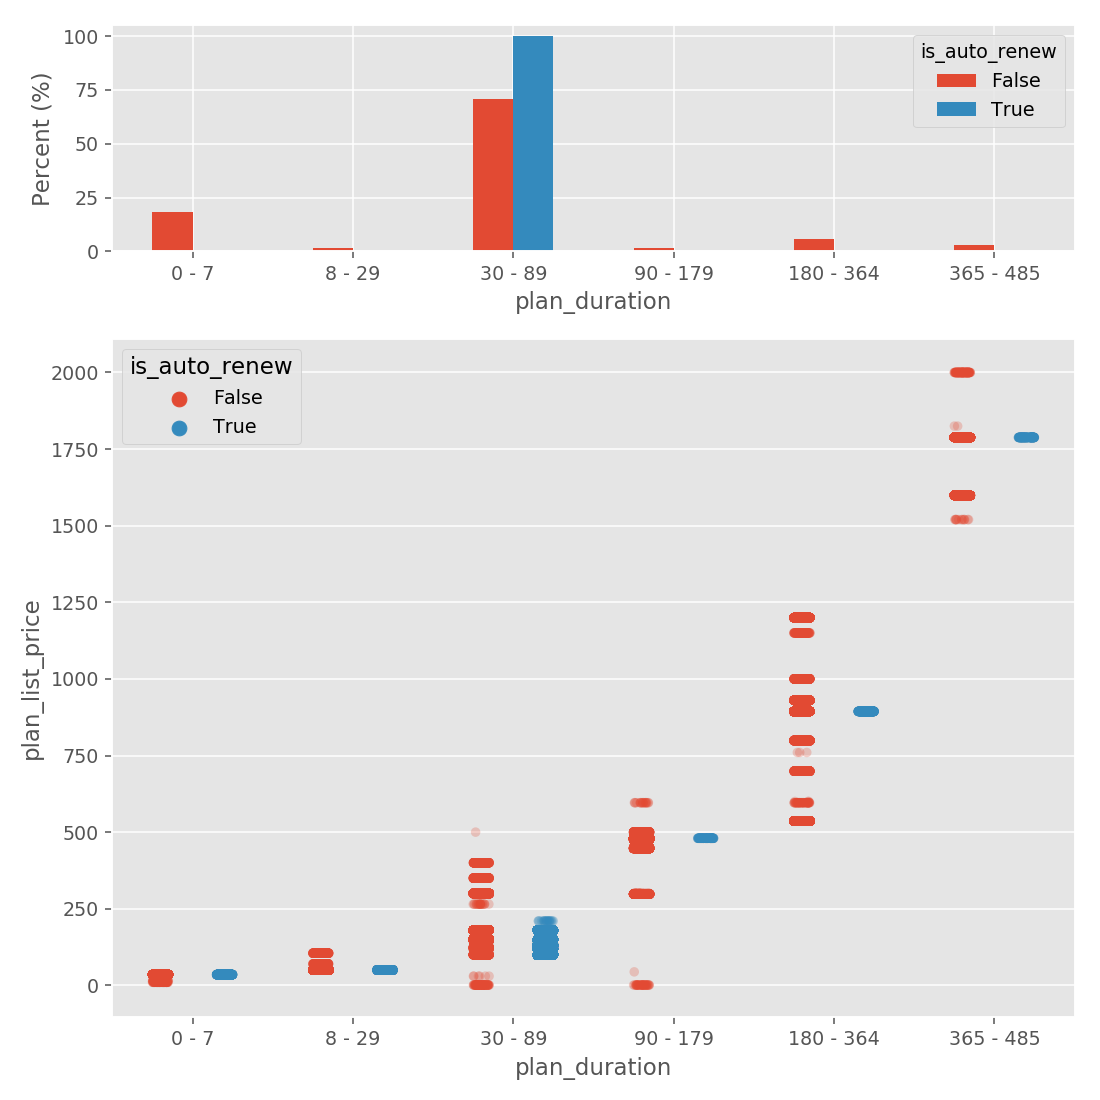

In [57]:
# prepare axis
_ , axCostDays = plt.subplots(2, 1, \
                              figsize=(8, 8), \
                              gridspec_kw=dict(height_ratios=[1, 3]))

# pivot on relevant columns, values can be anything as we are just counting here
df_plan = df_transac[df_transac.is_cancel == False].pivot_table(index = 'plan_duration', columns = 'is_auto_renew',\
                                 values = 'plan_list_price', aggfunc = 'count', fill_value = 0)

# normalize each column by counts
df_plan = df_plan.divide(df_plan.sum()) * 100

# make a bar plot for each auto renew state
df_plan.plot(kind = 'bar', ax = axCostDays[0])

# change tick orientation and add labels
axCostDays[0].tick_params(axis = 'x', rotation = 0)
axCostDays[0].set_ylabel('Percent (%)')
axCostDays[0].set_xlabel('plan_duration')


# use seaborn to add plan list price as another dimension
sns.stripplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
              dodge = True, jitter = True, alpha = 0.25,\
              data=df_transac, ax = axCostDays[1])
# sns.swarmplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
#               dodge = True, alpha = 0.25,\
#               data=df_transac, ax = axCostDays[1])

plt.tight_layout()

The Empirical cumulative distribution function (ECDF) can give us another view when there are too many points to plot.

<IPython.core.display.Javascript object>


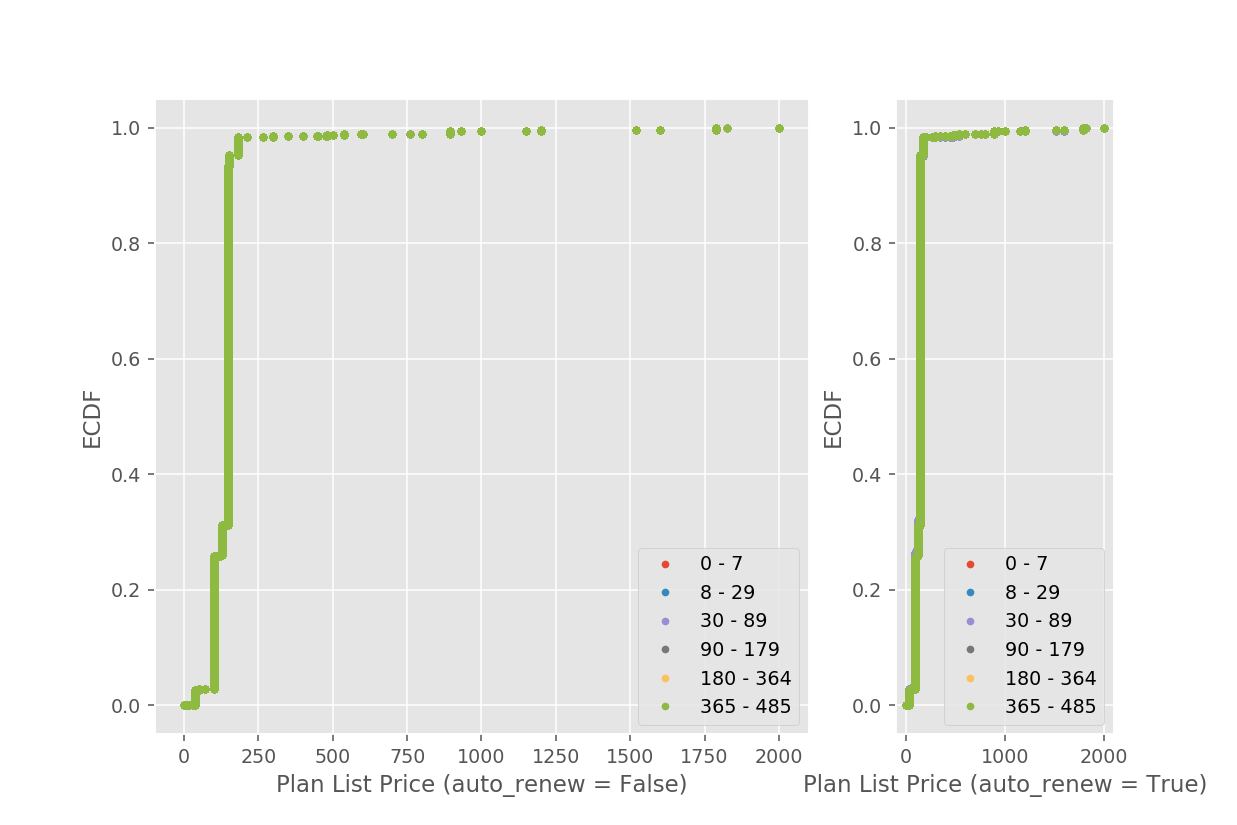

In [58]:
_ , axEcdf = plt.subplots(1, 2, figsize=(9, 6), gridspec_kw=dict(width_ratios=[3, 1]))

for i in range(2):
    # sort your data and plot it versus its percentage increment
    for pl in days_plan_labels:
        filt_pl = (df_transac.is_auto_renew == i ) & (df_transac.plan_duration == pl) & df_transac.is_cancel == False
        pl_x = df_transac.loc[filt_pl, 'plan_list_price'].sort_values().values
        pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
        axEcdf[i].plot(pl_x, pl_y, '.')
        axEcdf[i].set_xlabel('Plan List Price (auto_renew = ' + str(bool(i)) + ')'  )
        axEcdf[i].set_ylabel('ECDF')
    axEcdf[i].legend(days_plan_labels)

### List price vs paid price
Here we would like to know the difference in price between list price and actual amount paid.

In [59]:
# percent difference between plan price and price actually paid
df_discount_percent = 1 - (df_transac.actual_amount_paid/df_transac.plan_list_price)

It appears that an overwhelming majority of transcations do not have any discount (more than 92%) and some transaction were at no charge. Note that some percentage discount are negative which should not happen as one cannot pay more than the list price. <br>
Let's adjust the actual amount paid to match its corresponding list price in those cases.

<IPython.core.display.Javascript object>


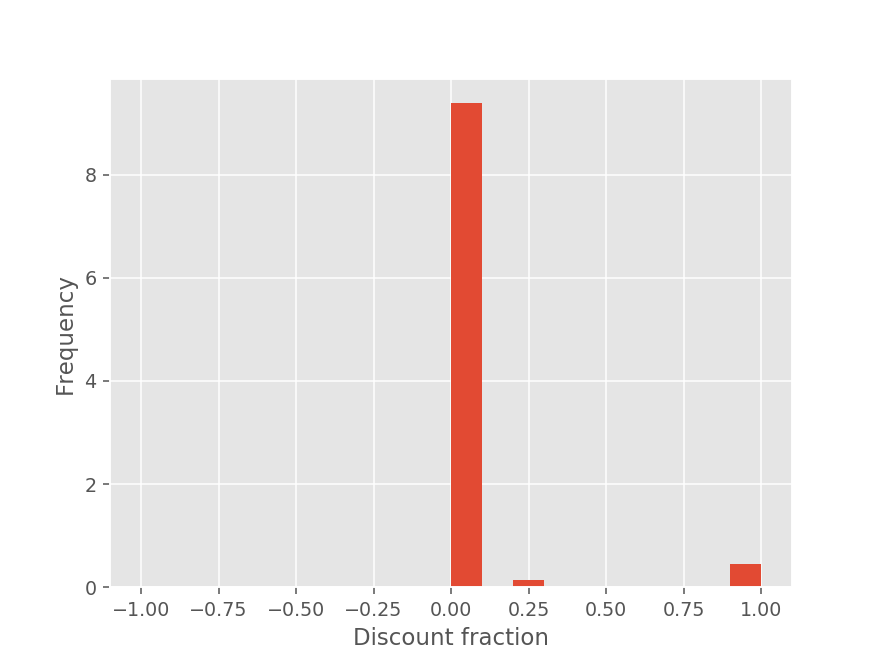

In [60]:
# plot histogram of discounts
_ , axDiscount = plt.subplots()

# plot histogram, bin by 10% intervals
_ = df_discount_percent[df_transac.is_cancel == False].plot(kind = 'hist', range = (-1,1), bins = 20, \
                                                              ax = axDiscount, density = True)

_ = axDiscount.set_xlabel('Discount fraction')
# Note: bin width is 0.1 thus normalization multiplies by 10 (divided by 0.1, see hist documentation).
# It means 100% corresponds to 10 on the y scale.

Same data using Empirical Cumulative Distribution function

<IPython.core.display.Javascript object>


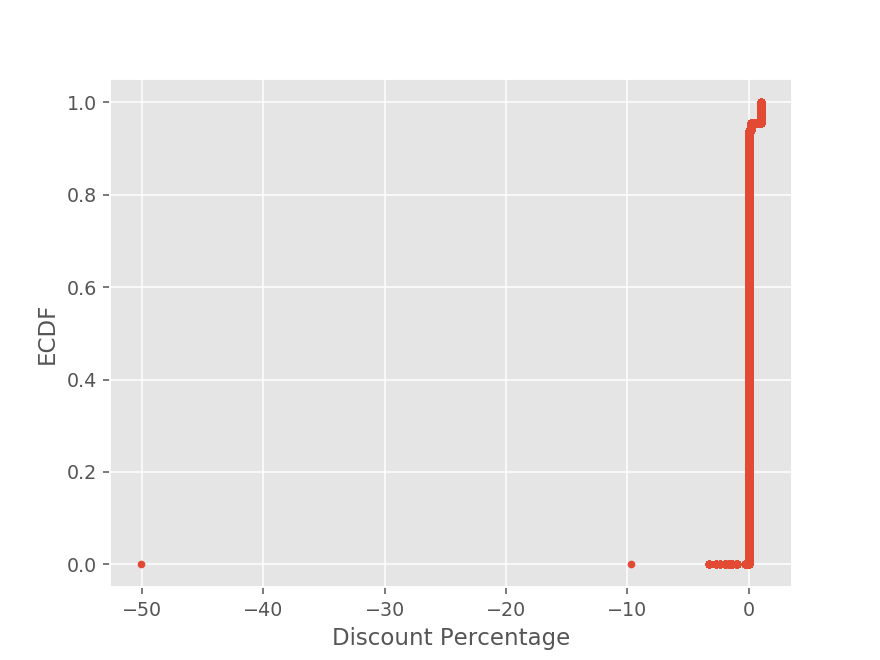

Text(0,0.5,'ECDF')

In [61]:
_ , axdisc = plt.subplots()
pl_x = df_discount_percent[df_transac.is_cancel == False].sort_values().values
pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
axdisc.plot(pl_x, pl_y, '.')
axdisc.set_xlabel('Discount Percentage')
axdisc.set_ylabel('ECDF')

In [62]:
# adjust actual amount paid where discount is negative
df_transac.loc[df_discount_percent < 0, 'actual_amount_paid'] = \
                                        df_transac.loc[df_discount_percent < 0, 'plan_list_price']